In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms, datasets
import matplotlib
import matplotlib.pyplot as plt
import time
import argparse
import numpy as np
from tqdm import tqdm

matplotlib.style.use('ggplot')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import files
files.upload

In [2]:
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

train_path = "/content/drive/MyDrive/Project/영남이공대/수업준비/AI_Analysis/example_dataset/hotdog-nothotdog/hotdog-nothotdog/train"
test_path = "/content/drive/MyDrive/Project/영남이공대/수업준비/AI_Analysis/example_dataset/hotdog-nothotdog/hotdog-nothotdog/test"


train_dataset = datasets.ImageFolder(
    root=train_path,
    transform=train_transform
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, shuffle=True,
)
val_dataset = datasets.ImageFolder(
    root=test_path,
    transform=val_transform
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=16, shuffle=False,
)

In [5]:
class LRScheduler():

    def __init__(self, optimizer, patience=5, min_lr=1e-6, factor=0.5):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor # LR을 factor배로 감소시킴
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            patience=self.patience,
            factor=self.factor,
            min_lr=self.min_lr,
            verbose=True
        )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

In [4]:
class EarlyStopping():
    def __init__(self, patience=5, verbose=False, delta=0, path=None):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False # 조기 종료를 의미하며 초기값은 False로 설정
        self.delta = delta # 오차가 개선되고 있다고 판단하기 위한 최소 변화량
        self.path = path
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        # 에포크 만큼 한습이 반복되면서 best_loss가 갱신되고, bset_loss에 진전이 없으면 조기종료 후 모델을 저장
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'Early Stopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}. Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [3]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--lr-scheduler', dest='lr_scheduler', action='store_true')
# parser.add_argument('--early-stopping', dest='early_stopping', action='store_true')
# parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1") #주피터 노트북에서 실행할때 필요합니다
# args = vars(parser.parse_args())

args = dict()
args['lr_scheduler'] =  True
args['early_stopping'] = True

model = models.resnet50(pretrained=True).to(device)

lr = 0.001
epochs = 100
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()


# 모델 학습 함수
def training(model, train_dataloader, train_dataset, optimizer, criterion):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size))
    for i, data in prog_bar:
        counter += 1
        data, target = data[0].to(device), data[1].to(device)
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / counter
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

# 콜백을 적용할 검증 함수
def validate(model, test_dataloader, val_dataset, criterion):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size))
    with torch.no_grad():
        for i, data in prog_bar:
            counter += 1
            data, target = data[0].to(device), data[1].to(device)
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()

        val_loss = val_running_loss / counter
        val_accuracy = 100. * val_running_correct / total
        return val_loss, val_accuracy

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s]


In [6]:
import torchsummary
torchsummary.summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
save_path = "/content/drive/MyDrive/Project/영남이공대/수업준비/AI_Analysis/example_dataset/hotdog-nothotdog/exp_save_pth/exp_save_01.pth"

lr_scheduler = LRScheduler(optimizer=optimizer, patience=5, min_lr=1e-6, factor=0.5)
early_stopping = EarlyStopping(patience=5, verbose=False, delta=0, path=save_path)

# 모델 학습
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = training(
        model, train_dataloader, train_dataset, optimizer, criterion
    )
    val_epoch_loss, val_epoch_accuracy = validate(
        model, val_dataloader, val_dataset, criterion
    )
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

    if args['lr_scheduler']:
        lr_scheduler(val_epoch_loss)
    if args['early_stopping']:
        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            break
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

Epoch 1 of 100
Training


266it [28:36,  6.45s/it]


Validating


100%|██████████| 25/25 [02:39<00:00,  6.39s/it]


Train Loss: 0.6916, Train Acc: 70.04
Val Loss: 0.6298, Val Acc: 67.00
Epoch 2 of 100
Training


266it [00:48,  5.53it/s]


Validating


100%|██████████| 25/25 [00:03<00:00,  6.42it/s]


Early Stopping counter: 1 out of 5
Train Loss: 0.4904, Train Acc: 76.61
Val Loss: 0.7159, Val Acc: 64.50
Epoch 3 of 100
Training


266it [00:46,  5.71it/s]


Validating


100%|██████████| 25/25 [00:03<00:00,  6.53it/s]


Train Loss: 0.4532, Train Acc: 78.95
Val Loss: 0.5734, Val Acc: 74.00
Epoch 4 of 100
Training


266it [00:47,  5.64it/s]


Validating


100%|██████████| 25/25 [00:03<00:00,  6.54it/s]


Early Stopping counter: 1 out of 5
Train Loss: 0.4328, Train Acc: 80.55
Val Loss: 0.7214, Val Acc: 69.50
Epoch 5 of 100
Training


266it [00:46,  5.72it/s]


Validating


100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


Early Stopping counter: 2 out of 5
Train Loss: 0.4379, Train Acc: 80.15
Val Loss: 0.6326, Val Acc: 67.25
Epoch 6 of 100
Training


266it [00:47,  5.63it/s]


Validating


100%|██████████| 25/25 [00:03<00:00,  6.46it/s]


Early Stopping counter: 3 out of 5
Train Loss: 0.3837, Train Acc: 82.51
Val Loss: 0.7839, Val Acc: 65.75
Epoch 7 of 100
Training


266it [00:46,  5.71it/s]


Validating


100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


Train Loss: 0.4059, Train Acc: 81.61
Val Loss: 0.5238, Val Acc: 75.50
Epoch 8 of 100
Training


266it [00:47,  5.63it/s]


Validating


100%|██████████| 25/25 [00:03<00:00,  6.49it/s]


Early Stopping counter: 1 out of 5
Train Loss: 0.3767, Train Acc: 83.19
Val Loss: 1.1368, Val Acc: 62.00
Epoch 9 of 100
Training


266it [00:46,  5.77it/s]


Validating


100%|██████████| 25/25 [00:04<00:00,  6.09it/s]


Early Stopping counter: 2 out of 5
Train Loss: 0.3718, Train Acc: 83.33
Val Loss: 0.6287, Val Acc: 74.25
Epoch 10 of 100
Training


266it [00:46,  5.68it/s]


Validating


100%|██████████| 25/25 [00:04<00:00,  5.68it/s]


Early Stopping counter: 3 out of 5
Train Loss: 0.3419, Train Acc: 84.51
Val Loss: 0.5993, Val Acc: 75.00
Epoch 11 of 100
Training


266it [00:45,  5.81it/s]


Validating


100%|██████████| 25/25 [00:04<00:00,  6.06it/s]


Early Stopping counter: 4 out of 5
Train Loss: 0.3510, Train Acc: 84.30
Val Loss: 0.5417, Val Acc: 76.50
Epoch 12 of 100
Training


266it [00:45,  5.79it/s]


Validating


100%|██████████| 25/25 [00:03<00:00,  6.59it/s]

Early Stopping counter: 5 out of 5
Training time: 40.690 minutes


In [ ]:
import pandas as pd

exp_result = pd.DataFrame()
exp_result['train_loss'] = train_loss
exp_result['train_accuracy'] = train_accuracy
exp_result['val_loss'] = val_loss
exp_result['val_accuracy'] = val_accuracy

exp_result.to_excel("/content/drive/MyDrive/Project/영남이공대/수업준비/AI_Analysis/example_dataset/hotdog-nothotdog/exp_result/exp_result_01.xlsx")

Text(0.5, 1.0, 'validation')

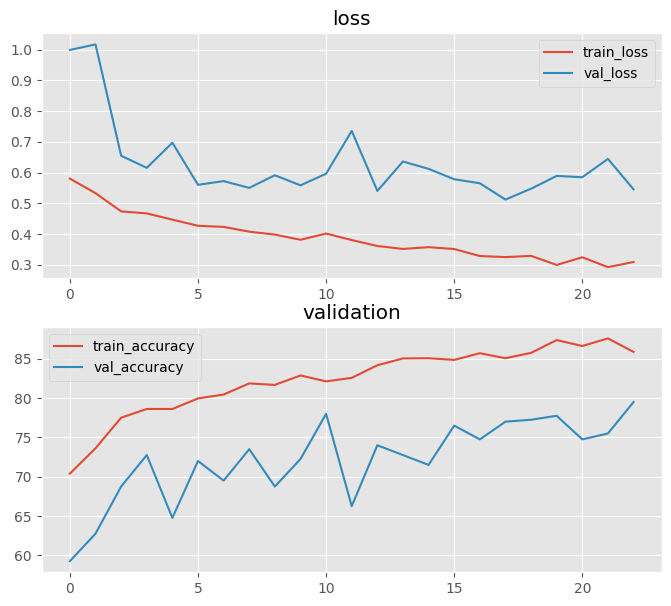

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(8,7))
ax[0].plot(exp_result['train_loss'], label="train_loss")
ax[0].plot(exp_result['val_loss'], label="val_loss")
ax[0].set_xlabel('eporch')
ax[0].legend()
ax[0].set_title("loss")
ax[1].plot(exp_result['train_accuracy'],label="train_accuracy")
ax[1].plot(exp_result['val_accuracy'],label="val_accuracy")
ax[1].legend()
ax[1].set_title("validation")